# WSI - ćwiczenie 5.
#### Sieci neuronowe

Klasa implementująca perceptron wielowarstwowy jest zawarta w pliku multilayer_perceptron.py.  
Funkcja implementująca uczenie perceptronu metodą stochastycznego najszybszego spadku jest zawarta w pliku sgd.py.

In [13]:
import sklearn.datasets
import numpy as np
import training_helpers
import sgd
import multilayer_perceptron
import plots
%matplotlib inline

Zaczynam od załadowania zbioru danych z biblioteki sklearn.<br>
Normalizuję dane, a następnie dzielę go na zbiór treningowy, walidacyjny i testowy.

In [14]:
TRAIN_SIZE = 0.8
VALID_SIZE = 0.1

X_all, Y_all = sklearn.datasets.load_wine(return_X_y=True)
Y_all_prepared, classes = training_helpers.prepare_targets(Y_all)
normalize_X, normalize_Y = training_helpers.get_normalizations(X_all, Y_all_prepared)
X_train, Y_train, X_validation, Y_validation, X_test, Y_test = training_helpers.triple_split(X_all, Y_all, TRAIN_SIZE, VALID_SIZE)

X_train_normal = training_helpers.normalize_sequence(X_train, normalize_X)
X_validation_normal = training_helpers.normalize_sequence(X_validation, normalize_X)
X_test_normal = training_helpers.normalize_sequence(X_test, normalize_X)

Y_train_normal = training_helpers.normalize_sequence(training_helpers.prepare_targets(Y_train)[0], normalize_Y)
Y_validation_normal = training_helpers.normalize_sequence(training_helpers.prepare_targets(Y_validation)[0], normalize_Y)
Y_test_normal = training_helpers.normalize_sequence(training_helpers.prepare_targets(Y_test)[0], normalize_Y)

print(f"Ilość atrybutów w jednej próbce: {X_all.shape[1]}\n")

print(f"Zbiór treningowy: {len(X_train)} elementów - {TRAIN_SIZE} początkowego zbioru")
print(f"Zbiór walidacyjny: {len(X_validation)} elementów - {VALID_SIZE} początkowego zbioru")
print(f"Zbiór testowy: {len(X_test)} elementów - {1 - TRAIN_SIZE - VALID_SIZE:.5} początkowego zbioru")

Ilość atrybutów w jednej próbce: 13

Zbiór treningowy: 142 elementów - 0.8 początkowego zbioru
Zbiór walidacyjny: 18 elementów - 0.1 początkowego zbioru
Zbiór testowy: 18 elementów - 0.1 początkowego zbioru


Na potrzeby zadania zostały przygotowane następujące popularne funkcje aktywacji:

In [15]:
ACTIVATIONS = {
    "relu": (lambda x: max(x, 0.),
             lambda x: float(x >= 0)),
    "tanh": (lambda x: np.tanh(x),
             lambda x: (1 / np.cosh(x)) ** 2),
    "logistic": (lambda x: np.exp(x) / (1 + np.exp(x)),
                 lambda x: np.exp(x) / ((1 + np.exp(x)) ** 2))
}

Potem następuje właściwy trening sieci neuronowej.

In [16]:
EPOCHS = 100
ACTIVATION_NAMES = list(ACTIVATIONS.keys())
LEARNING_RATES = [10 ** k for k in range(-3, 2)]
BATCH_SIZES = []
batch_size = 1
while(batch_size < len(X_train_normal)):
    BATCH_SIZES.append(batch_size)
    batch_size *= 5
BATCH_SIZES.append(len(X_train_normal))
SHAPES = [
    [],
    [len(X_train_normal[0]) // 2],
    [(len(X_train_normal[0]) + len(Y_train_normal[0])) // 2],
    [len(X_train_normal[0]) // 2, len(X_train_normal[0]) // 4],
    [len(X_train_normal[0]), (len(X_train_normal[0]) + len(Y_train_normal[0])) // 2 ,len(Y_train_normal[0])],
    [len(X_train_normal[0]) // 4, len(X_train_normal[0]) // 2, len(X_train_normal[0]) // 4]
]

best_error = np.inf
errors_by_activation = [[] for _ in ACTIVATION_NAMES]
errors_by_learning_rate = [[] for _ in LEARNING_RATES]
errors_by_batch_size = [[] for _ in BATCH_SIZES]
errors_by_shape = [[] for _ in SHAPES]

for i, activation in enumerate(ACTIVATION_NAMES):
    for j, learning_rate in enumerate(LEARNING_RATES):
        for k, batch_size in enumerate(BATCH_SIZES):
            for l, shape in enumerate(SHAPES):

                perceptron, error, mses = sgd.stochastic_gradient_descent(
                    X_train_normal, Y_train_normal, X_validation_normal, Y_validation_normal,
                    ACTIVATIONS[activation], shape, learning_rate, EPOCHS, batch_size
                )

                if best_error >= error:
                    best_error = error
                    best_activation = activation
                    best_learning_rate = learning_rate
                    best_batch_size = batch_size
                    best_perceptron = perceptron
                    best_shape = shape
                    best_mses = mses

                errors_by_activation[i].append(error)
                errors_by_learning_rate[j].append(error)
                errors_by_batch_size[k].append(error)
                errors_by_shape[l].append(error)

Najlepszy perceptron uzyskano dla funkcji aktywacji: tanh, tempa nauczania: 0.1, rozmiaru pakietu: 1 i kształtu warstw ukrytych: [3, 6, 3]
Błąd wynosił tam 0.00003


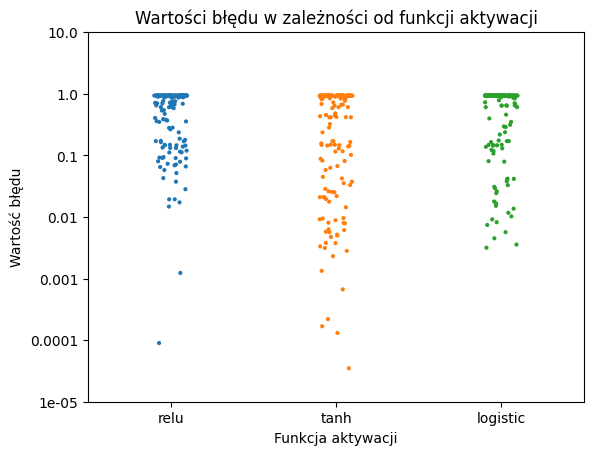

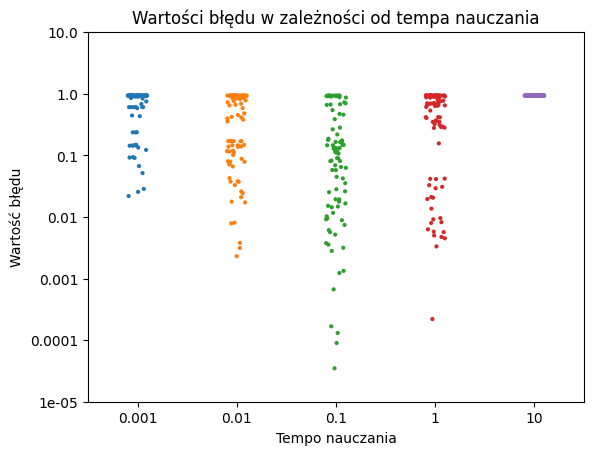

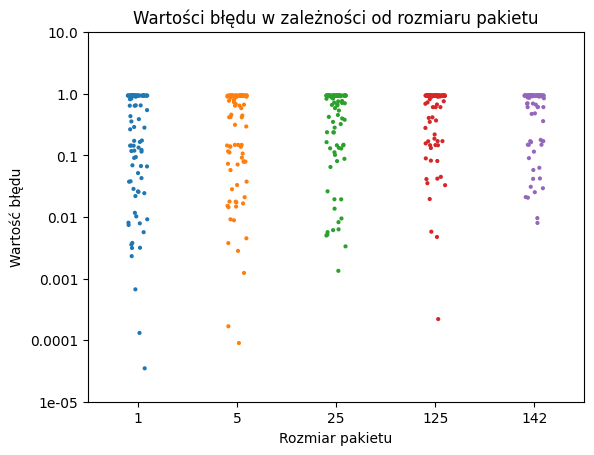

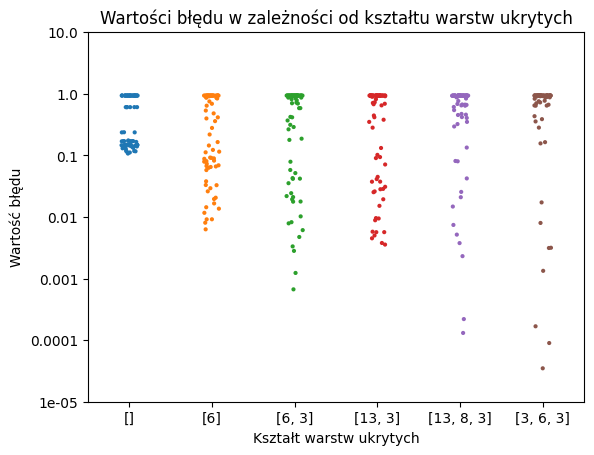

In [21]:
import importlib
importlib.reload(plots)

print(f"Najlepszy perceptron uzyskano dla funkcji aktywacji: {best_activation}, "
      f"tempa nauczania: {best_learning_rate}, "
      f"rozmiaru pakietu: {best_batch_size} "
      f"i kształtu warstw ukrytych: {best_shape}",
      f"Błąd wynosił tam {best_error:.5f}", sep="\n")

MAX_ERROR = 2

errors_by_activation_l = [[np.log10(min(error, MAX_ERROR)) for error in errors] for errors in errors_by_activation]
errors_by_learning_rate_l = [[np.log10(min(error, MAX_ERROR)) for error in errors] for errors in errors_by_learning_rate]
errors_by_batch_size_l = [[np.log10(min(error, MAX_ERROR)) for error in errors] for errors in errors_by_batch_size]
errors_by_shape_l = [[np.log10(min(error, MAX_ERROR)) for error in errors] for errors in errors_by_shape]

plots.generate_log_strip_plot(
      errors_by_activation_l, ACTIVATION_NAMES,
      "Wartości błędu w zależności od funkcji aktywacji",
      "Funkcja aktywacji", "Wartość błędu")

plots.generate_log_strip_plot(
      errors_by_learning_rate_l, LEARNING_RATES,
      "Wartości błędu w zależności od tempa nauczania",
      "Tempo nauczania", "Wartość błędu")

plots.generate_log_strip_plot(
      errors_by_batch_size_l, BATCH_SIZES,
      "Wartości błędu w zależności od rozmiaru pakietu",
      "Rozmiar pakietu", "Wartość błędu")

plots.generate_log_strip_plot(
      errors_by_shape_l, SHAPES,
      "Wartości błędu w zależności od kształtu warstw ukrytych",
      "Kształt warstw ukrytych", "Wartość błędu")

In [18]:
predictions = np.array([classes[np.argmax(prediction)] for prediction in best_perceptron.predict_all(X_all)])